## Financial Portfolio Analysis

### Overview
This notebook analyzes transaction data, user behavior, risk metrics and conducts vintage analysis.

### Key Metrics
- User growth
- Transaction volume and value trends  
- Installment plan preferences
- DPD (Days Past Due) risk analysis
- Vintage analysis for first DPD transactions started each month

### Assumptions:
- Data quality is good - no issues were experienced when building this report
- Metrics and methodology are assumed as correct and anomalies are actual insights to analyze

In [40]:
from vb.sql_execution import SQL_Executor
from vb.queries import SQL_Queries
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd


executor = SQL_Executor()
query = SQL_Queries()


def smart_format(x: int, pos) -> str:
    if x >= 1000000:
        return f"{x / 1000000:.1f}M"
    elif x >= 1000:
        return f"{x / 1000:.0f}k"
    else:
        return f"{x:.0f}"


def create_labels(bins_inc: list[int]) -> tuple[list[str], list[str]]:
    labels = []
    bins = bins_inc + [float("inf")]
    for i in range(len(bins) - 1):
        if bins[i + 1] == float("inf"):
            label = f"{bins[i]}+"
        else:
            label = f"{bins[i]}-{bins[i + 1] - 1}"
        labels.append(label)
    return bins, labels


def group_by_column(
    df: pd.DataFrame,
    bins_inc: list[int],
    target_column: str,
    column: str,
    drop_column: str = None,
) -> pd.DataFrame:
    bins, labels = create_labels(bins_inc)

    if drop_column:
        df = df.drop(columns=drop_column)

    group_column = f"group_{column}"
    df[group_column] = pd.cut(df[column], bins=bins, labels=labels)

    output_column = f"{target_column}_rate"
    df = df.groupby(group_column, observed=True).agg(
        **{output_column: (target_column, lambda x: (x.mean() * 100).round(2))}
    )

    return df


def dpd_calc(df: pd.DataFrame) -> pd.DataFrame:
    scheduled_date = pd.to_datetime(df["scheduled_date"])
    payment_date = pd.to_datetime(df["payment_date"])
    today = pd.Timestamp.today()

    df["dpd"] = 0

    df.loc[payment_date > scheduled_date, "dpd"] = (
        payment_date - scheduled_date
    ).dt.days

    df.loc[payment_date.isna(), "dpd"] = (today - scheduled_date).dt.days.clip(lower=0)

    df = df.drop(columns=["payment_date", "scheduled_date"])

    return df


def vintage_plot(df, year):
    df = df[df["first_month"].astype(str).str[:4] == year]

    df.pivot(
        index="installment_number", columns="first_month", values="dpd90_pct"
    ).plot(
        kind="line",
        figsize=(20, 5),
        title=f"Vintage analysis of percent of first transactions in month for year {year}",
    )

    plt.xlabel("Installment number")
    plt.ylabel("% of DPD transactions in month")
    plt.legend(title='Month')  

## Portfolio analysis

In [41]:
users_aggregated_df = executor.execute_query(query.Portfolio().users_aggregated())
transactions_aggregated_df = executor.execute_query(
    query.Portfolio().transactions_aggregated()
)

installment_plans_df = executor.execute_query(query.Portfolio().installment_plans())
popular_categories_df = executor.execute_query(query.Portfolio().popular_categories())
new_and_active_customers_df = users_aggregated_df.merge(
    transactions_aggregated_df, how="left", on="month"
).set_index("month")

### User Growth & Activity
- Explosive growth in Q4 2024, active users 4x increase to 4,000
- New user acquisition increased to 1200 per month
- Active users growing faster than new acquisitions

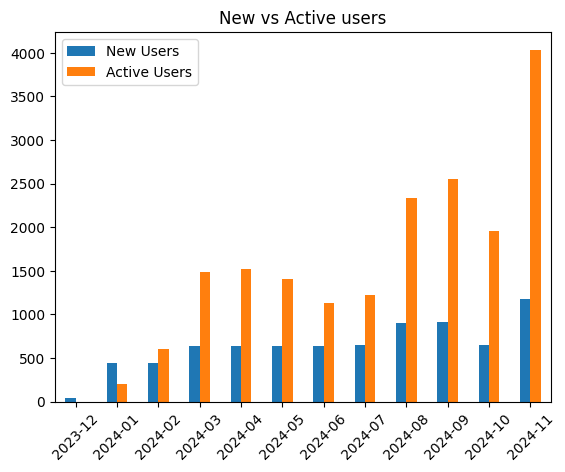

In [42]:
new_and_active_customers_ax = new_and_active_customers_df[
    ["new_users_count", "active_users_count"]
].plot(kind="bar", rot=45, xlabel="", legend=True, title="New vs Active users")
new_and_active_customers_ax.legend(["New Users", "Active Users"]);

### Transaction Patterns
- November 2024 surge: 6,000 transactions worth $2.3M
- Transaction volume generally follows transaction count - no rare high amount transactions

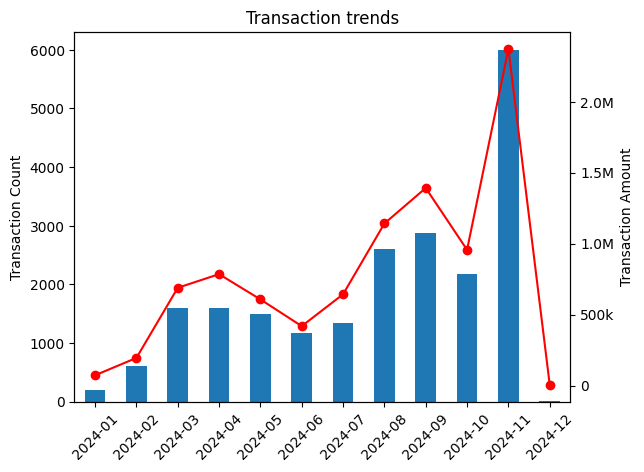

In [43]:
transactions_aggregated_index_df = transactions_aggregated_df.set_index("month")
ax = transactions_aggregated_index_df["transactions_count"].plot(
    kind="bar", rot=45, xlabel="", title="Transaction trends"
)
ax2 = ax.twinx()
ax2.plot(
    transactions_aggregated_index_df.index,
    transactions_aggregated_index_df["sum_amount"],
    color="red",
    marker="o",
)
ax.set_ylabel("Transaction Count")
ax2.set_ylabel("Transaction Amount")
ax2.yaxis.set_major_formatter(FuncFormatter(smart_format))

### Product Preferences
- 4-installment plans dominate (1.3M peak usage)
- Shorter terms are preferred - 4>6>12>24 installment hierarchy

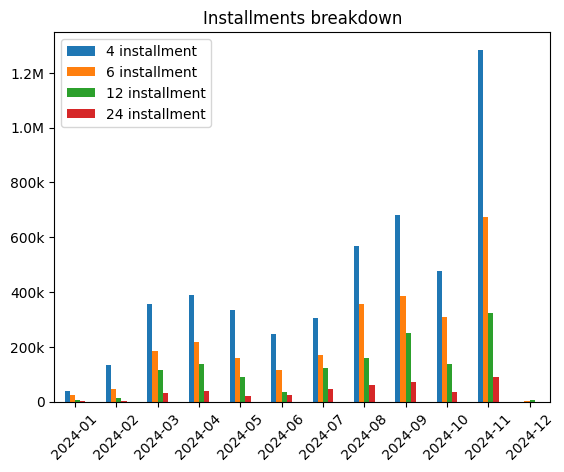

In [44]:
installment_df = installment_plans_df.set_index("month")
installment_ax = installment_df[
    [
        "4_installment_transaction_volume",
        "6_installment_transaction_volume",
        "12_installment_transaction_volume",
        "24_installment_transaction_volume",
    ]
].plot(kind="bar", rot=45, xlabel="", title="Installments breakdown")
plt.legend(["4 installment", "6 installment", "12 installment", "24 installment"])
installment_ax.yaxis.set_major_formatter(FuncFormatter(smart_format))

### Category Analysis
- Electronics drive most (70%) of transaction volume
- Clear category dominance with over 6000 electronics transactions
- Top categories are not very varied

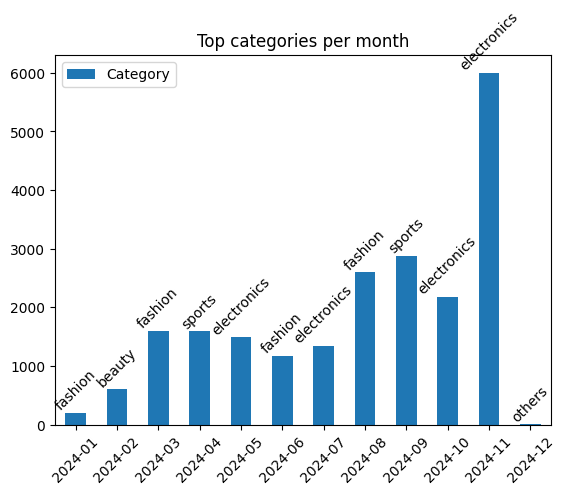

In [45]:
ax = popular_categories_df.set_index("month")[["category_transaction_count"]].plot(
    kind="bar", title="Top categories per month"
)
ax.bar_label(
    ax.containers[0],
    labels=popular_categories_df.set_index("month")["category"],
    rotation=45,
)
plt.xticks(rotation=45)
plt.xlabel("")
plt.legend(["Category"]);

## Group Risk Analysis
**Key Insight** - Income is an even stronger predictor than age, with a 25 percentage point difference between lowest and highest income tiers.

In [46]:
installments_df = executor.execute_query(query.DPD().installments())
transactions_with_age_income_df = executor.execute_query(
    query.DPD().transactions_with_age_income()
)

group_dpd_df = dpd_calc(installments_df)
group_dpd_df["dpd90"] = (group_dpd_df["dpd"] >= 90).astype(int)
group_dpd_df = group_dpd_df.groupby("transaction_id").agg({"dpd90": "max"})
group_dpd_df = transactions_with_age_income_df.merge(
    group_dpd_df, on="transaction_id", how="left"
).fillna(0)

### Age-Based Risk Analysis
- **Youngest borrowers (18-25)** - Highest risk at 50% DPD90 rate
- **Middle-aged (26-35, 36-50)** - Moderate risk at 30% DPD90 rate  
- **Older borrowers (51+)** - Lowest risk at 25% DPD90 rate
- Risk decreases significantly with age (28 percentage point spread)

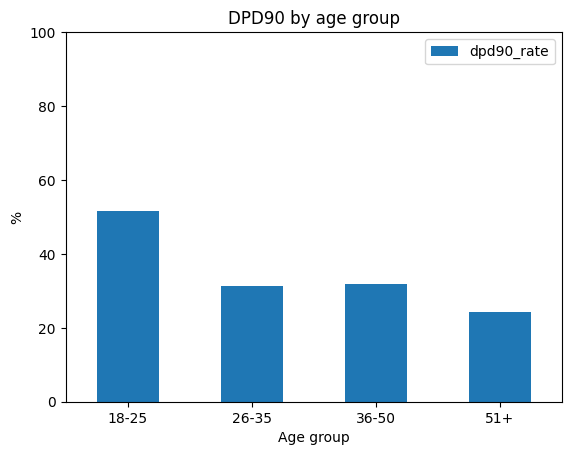

In [47]:
bins = [18, 26, 36, 51]
dpd_rates_age = group_by_column(group_dpd_df, bins, "dpd90", "age", "income")
dpd_rates_age.plot(
    kind="bar",
    title="DPD90 by age group",
    rot=0,
    ylim=(0, 100),
    xlabel="Age group",
    ylabel="%",
);

### Income-Based Risk Analysis  
- **Low income (<$30K)** - Highest risk at 55% DPD90 rate
- **Middle income ($30K-$60K)** - Moderate risk at 35% DPD90 rate
- **High income ($60K+)** - Lowest risk at 30% DPD90 rate
- **$30K is risk threshold** - substantial decrease of risk after passing it

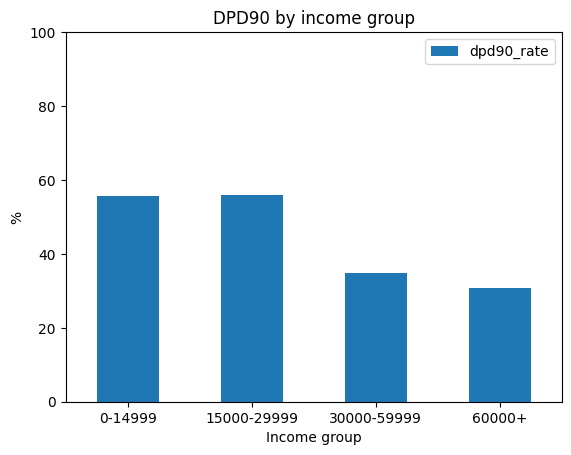

In [48]:
bins = [0, 15000, 30000, 60000]
dpd_rates_income = group_by_column(group_dpd_df, bins, "dpd90", "income", "age")
dpd_rates_income.plot(
    kind="bar",
    title="DPD90 by income group",
    rot=0,
    ylim=(0, 100),
    xlabel="Income group",
    ylabel="%",
);

## Vintage Analysis

In [49]:
transactions_df = executor.execute_query(query.DPD().transactions())
installments_df = executor.execute_query(query.DPD().installments())
transactions_df = transactions_df.sort_values("transaction_date")
transactions_df["transaction_date"] = pd.to_datetime(
    transactions_df["transaction_date"]
)
transactions_df["first_month"] = transactions_df["transaction_date"].dt.to_period("M")
transactions_df = transactions_df.drop(columns=["transaction_date"])
transactions_df = transactions_df.groupby("user_id").first().reset_index()
dpd_df = transactions_df.merge(installments_df, how="left", on="transaction_id")
dpd_df = dpd_calc(dpd_df)
dpd_df["dpd90"] = (dpd_df["dpd"] >= 90).astype(int)
dpd_df = (
    dpd_df.groupby(["first_month", "user_id", "installment_number"])["dpd90"]
    .max()
    .reset_index()
)
dpd_df = (
    dpd_df.groupby(["first_month", "installment_number"])["dpd90"].mean().reset_index()
)
dpd_df["dpd90_pct"] = dpd_df["dpd90"] * 100

### 2022 
- **Normal behavior** - Most cohorts show DPD rates under 20% through installment 12
- **High risk period** - Installments 6-9 show highest stress across cohorts  
- **Outlier event** - 2022-09 cohort shows dramatic spike to ~100% at installment 20
- **Seasonal patterns** - Q1 cohorts (Jan-Mar) show more stable performance

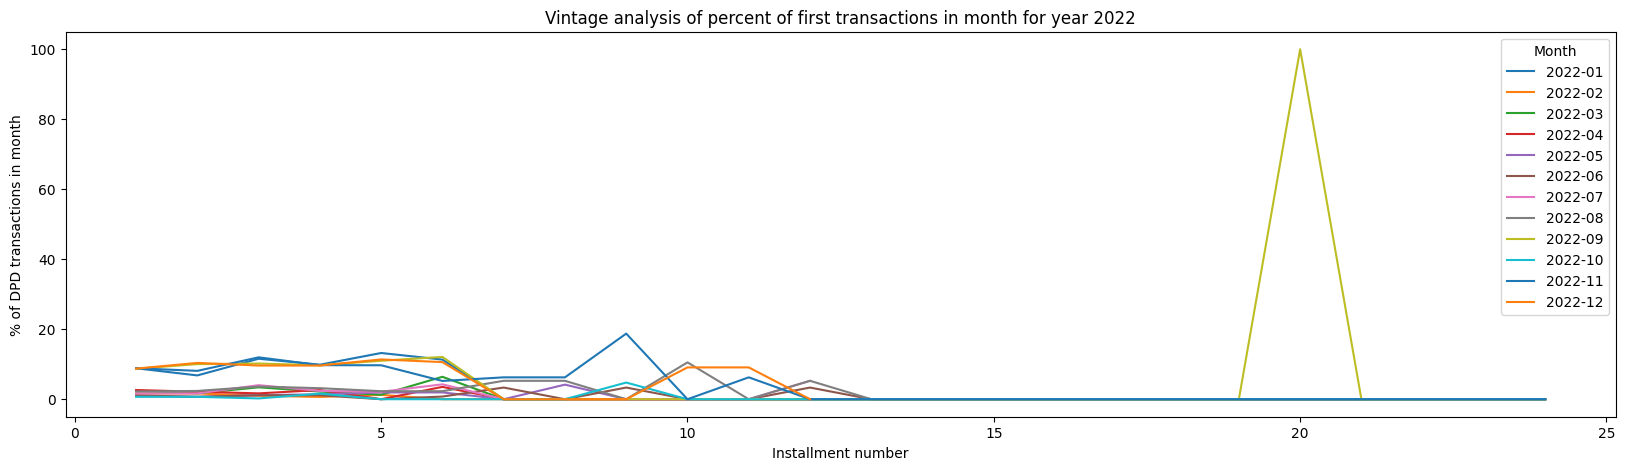

In [50]:
vintage_plot(dpd_df, "2022")

### 2023
- **Multiple spikes** - Several cohorts hit 100% DPD rates at different installments (12-24)
- **Quality over time** - Much higher peak rates than 2022
- **Systematic issues** - Pattern suggests some possible market or process issues

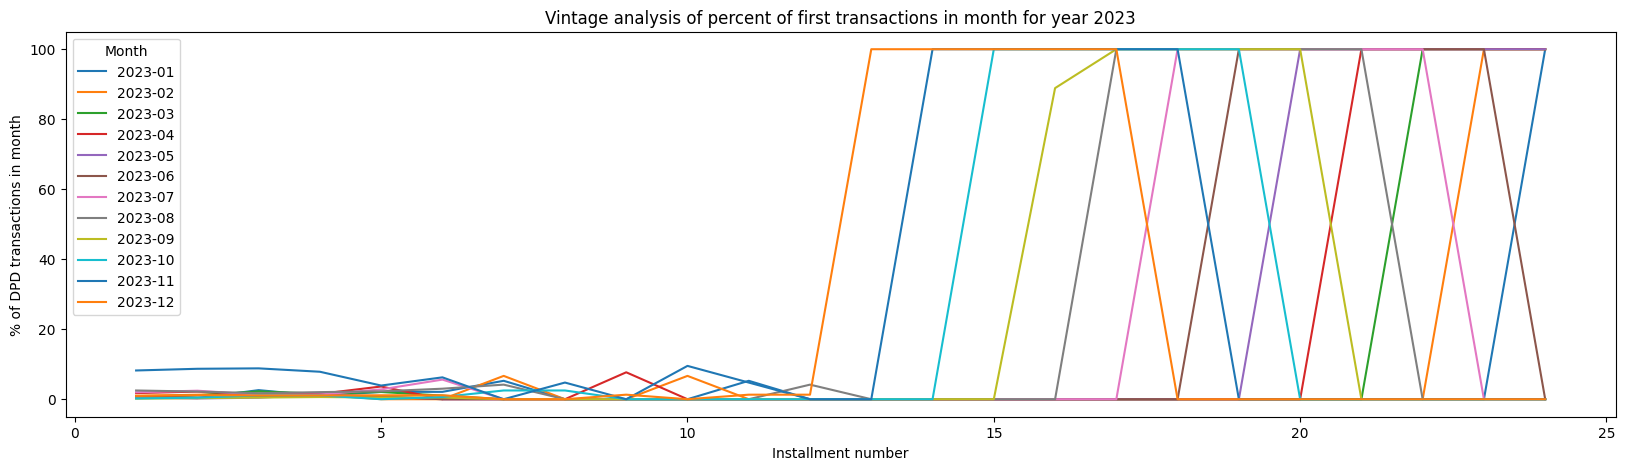

In [51]:
vintage_plot(dpd_df, "2023")

### 2024
- **Early failures** - Cohorts reaching 100% DPD very early (installments 3-15)
- **Variable patterns** - Big spikes followed by immediate drops to 0%

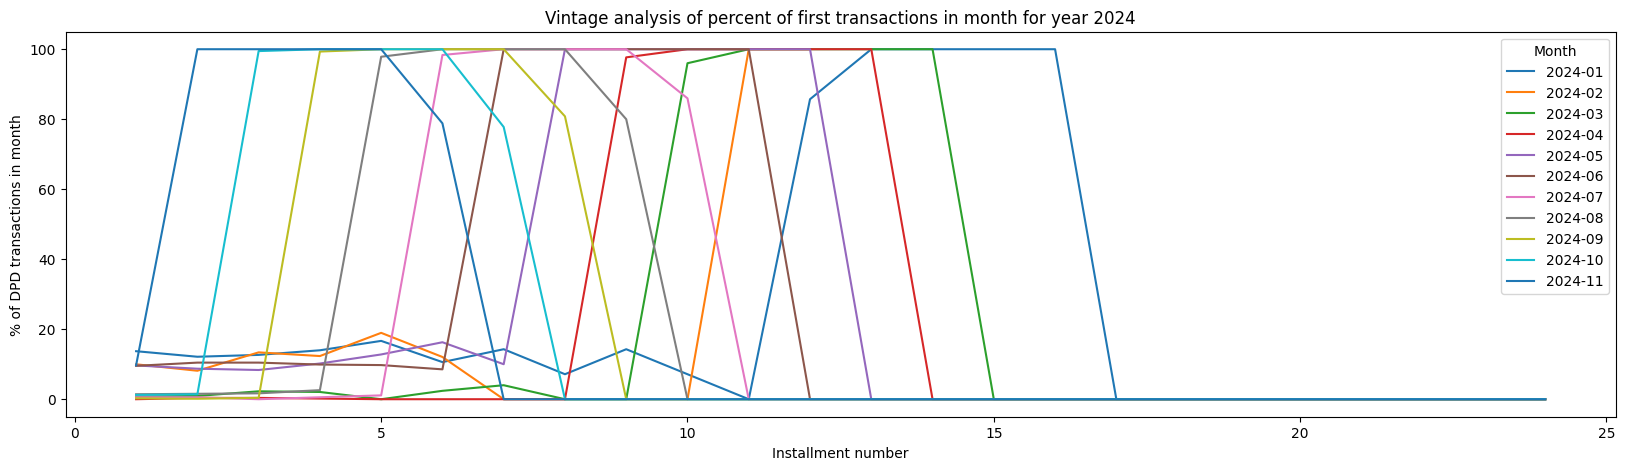

In [52]:
vintage_plot(dpd_df, "2024")